### Baseline Model Demo

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
# nltk.download('wordnet')
# nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook
import random
import json
import requests
import configparser

#### Setup Functions

In [19]:
# utility functions

# display image and caption from thumbnails folder given list of ids
def show_images(imgids, image_to_caption):
    for img in imgids:
        try:
            plt.figure();
            print('Caption:', image_to_caption[img])
            img=mpimg.imread('../data/thumbnail/'+img+'.jpg')
            imgplot = plt.imshow(img);
        except:
            plt.close()
            print(img)
        print()
    plt.show()
    
# draw random test id and exclude from train data
def train_test(train):
    test_id = random.choice(train.index)
    test_tags = train.pop(item = test_id)
    return test_id, test_tags, train

# from src/api_helper.py
def tagging_api(body):
    """
    Tags articles using API call
    """
    #retrieve password
    config = configparser.ConfigParser()
    config.read('../password.ini')
    apikey = config['key']['apikey']

    #format request to tagging api 
    datasets = ['subject', 'geography', 'organization', 'person']
    request_url = f'http://cv.ap.org/annotations?apikey={apikey}'
    data = {"meta": {
                "features": [
                    {"name": "ap",
                    "authorities": datasets}],
                    "accept": "application/ld+json"},
                    "document": body,
                    "document_contenttype": "text/plain"}
    response = requests.post(url = request_url, json = data)
    if response.status_code == 200:
        json_data = response.json()
        #some text can't generate tags
        if not json_data['annotation']:
            return []
        json_data = json.loads(json_data['annotation'])
        tags = []
        #current method extracts annotation 
        #if there is a type field labeled http://www.w3.org/2004/02/skos/core#Concept
        #seems to be a relevant tag 
        #otherwise seems to be a category of tag e.g. Subject 
        for j in json_data:
            try:
                if j['@type'][0] == 'http://www.w3.org/2004/02/skos/core#Concept':
                    tags.append(j['http://www.w3.org/2004/02/skos/core#prefLabel'][0]['@value'])
            except:
                pass
        return tags
    else:
        return response.status_code

In [20]:
# Tagging API Demo use case
text =  "Georgia Tech’s schedule to this point has been light, with a season-opener against Tennessee the hardest test to this" \
    " point. Miami (4-0, 2-0) is looking for its first 10-game win streak since 2003-04. If it is looking for inspiration, Georgia Tech can look to" \
" 2015, when it stunned ninth-ranked Florida State on a last-second blocked field goal return for a 78-yard touchdown. FSU entered that" \
" game with a 29-game win streak over ACC opponents. Miami has beaten its last six ACC foes. Georgia Tech ranks 31st in points" \
" (36.5), 35th in yards per play (6.35) and unsurprisingly, second nationally in rushing yards per game (396.0). The Yellow Jackets" \
" average 5.91 yards per carry (10th), which ranks behind Miami’s 6.40, which is sixth. Georgia Tech hasn’t finished behind Miami — or" \
" anywhere outside the top 20 — in rushing yards per carry since at least 2008.Quarterback TaQuon Marshall, a converted running back" \
" (current running back, really, in Paul Johnson‘s offense), has been a capable leader"
print(tagging_api(text))

['TaQuon Marshall', 'College football', 'Atlantic Coast Conference football', 'Georgia Tech Yellow Jackets football', 'Football', 'College sports', 'Sports', 'Paul Johnson']


#### Model Definitions
- Text to Text KNN
- Text to Image KNN

In [46]:
# Text to Text KNN model
class Text_to_Text_KNN():
    # @param k: number of neighbors to return
    def __init__(self, k, article_to_image):
        self.k = k
        self.article_to_image = article_to_image

    # @param train: training set of articles
    # @article_to_image: map of images associated with each article
    def fit(self, train):
        self.train = train

    # returns number of normalized exact tag overlap
    def baseline_score(self,t0,t1):
        return len(set(t0) & set(t1))/len(t0)

    # @param sim: function to return similarity score
    # @param test: article to predict in form (id, tags)
    def predict(self, test_tags):
        ranks = {}
        train = self.train.copy()
        train_ids, train_tags_all = train.index, train.values

        # go through ids
        for ind in range(len(train_ids)):
            train_id, train_tags = train_ids[ind], train_tags_all[ind]
            s = self.baseline_score(test_tags, train_tags)
            if len(ranks) < self.k:
                ranks[len(ranks)] = (train_id, s)
            elif s > min(ranks.values(), key=lambda x:x[1])[1]:
                key = min(ranks.keys(), key=lambda x:ranks[x][1])
                ranks[key] = (train_id, s)
        ranks = sorted(ranks.values(), key = lambda x:x[1], reverse=True)

        # map to predicted images
        train_ids = []
        pred = {}
        for train_id, s in ranks:
            img_ids = self.article_to_image[str(train_id)]
            for img_id in img_ids:
                pred[img_id] = s
            train_ids.append(train_id)
        return train_ids, pred

    def score(self):
        pass

In [47]:
# Text to Image KNN model
class Text_to_Image_KNN():
    # @param k: number of neighbors to return
    def __init__(self, k):
        self.k = k

    # @param train: training set of image tags
    def fit(self, train):
        self.train = train

    # returns number of normalized exact tag overlap
    def baseline_score(self,t0,t1):
        return len(set(t0) & set(t1))/len(t0)

    # @param sim: function to return similarity score
    # @param test: article to predict in form (id, tags)
    # returns: pred_ids, pred_scores
    def predict(self, test_tags):
        ranks = {}
        train = self.train.copy()
        train_ids, train_tags_all = train.index, train.values

        # go through ids
        for ind in range(len(train_ids)):
            train_id, train_tags = train_ids[ind], train_tags_all[ind]
            s = self.baseline_score(test_tags, train_tags)
            if len(ranks) < self.k:
                ranks[len(ranks)] = (train_id, s)
            elif s > min(ranks.values(), key=lambda x:x[1])[1]:
                key = min(ranks.keys(), key=lambda x:ranks[x][1])
                ranks[key] = (train_id, s)
        ranks = sorted(ranks.values(), key = lambda x:x[1], reverse=True)
        return [r[0] for r in ranks], [r[1] for r in ranks]

    def score(self):
        pass

#### Data Reformatting

In [23]:
# clean training data 
datadir = '../data/clean_data/'

tag_ref = {'ap_category':'category_code',
           'event':'event_tag',
           'org':'org_tag',
           'org_industry':'org_industry_tag',
           'person':'person_tag',
           'person_team':'person_team_tag',
           'person_type':'person_type',
           'place':'place_tag',
           'subject':'subject_tag',
           'summary':'headline_extended'
          }

article_feat_csvs = ['article_person.csv','article_org.csv','article_place.csv','article_subject.csv']
image_feat_csvs = ['image_person.csv','image_org.csv','image_place.csv','image_subject.csv']
train = pd.Series([])
image_train = pd.Series([])
for csv_file in tqdm_notebook(os.listdir(datadir)):
    if csv_file in article_feat_csvs: 
        df = pd.read_csv(datadir+csv_file)
        feat = csv_file[8:-4]
        g = df.groupby("id")[tag_ref[feat]]
        if train.empty:
            train = g.apply(lambda x: list(x.astype(str).str.lower()))
        else:
            g = g.apply(lambda x: list(x.astype(str).str.lower()))
            train = train.combine(g, lambda x1, x2: list(set(x1+x2)), fill_value=[])
    if csv_file in image_feat_csvs:
        df = pd.read_csv(datadir+csv_file)
        feat = csv_file[6:-4]
        g = df.groupby("id")[tag_ref[feat]]
        if image_train.empty:
            image_train = g.apply(lambda x: list(x.astype(str).str.lower()))
        else:
            g = g.apply(lambda x: list(x.astype(str).str.lower()))
            image_train = image_train.combine(g, lambda x1, x2: list(set(x1+x2)), fill_value=[])

In [25]:
# map article-image associations
df = pd.read_csv(datadir + 'image_summary.csv')
g = df.groupby("article_idx")['id']
article_images = g.apply(list).to_dict()
image_to_caption = df.set_index('id')['summary']

#### Test Case 1: Randomly Selected Article as Input

Example Input

Test Article Tags: ['political parties', 'government and politics', 'joe manchin', 'social issues', 'war and unrest', 'political organizations', 'online media', 'legislation', 'barack obama', 'political issues', 'gun politics', 'u.s. democratic party', 'south asia', 'funerals and memorial services', 'general news', 'united states', 'human rights and civil liberties', 'joe donnelly', 'asia', 'state governments', 'social affairs', 'government regulations', 'media', 'india', 'u.s. republican party', 'texas', 'legislature', 'donald trump', 'social media', 'dianne feinstein', 'weapons laws and regulations', 'terrorism', 'john cornyn', 'kashmir', 'north america']

Caption: FILE - In this Dec. 10, 2018 file photo, villagers attend the joint funeral of Kashmiri teenage rebels Saqib Bilal Sheikh and Mudasir Rashid Parray at Hajin village, north of Srinagar, Indian controlled Kashmir. On Friday, Aug. 9, 2019, The Associated Press reported on a video circulating online that was incorrectly identi

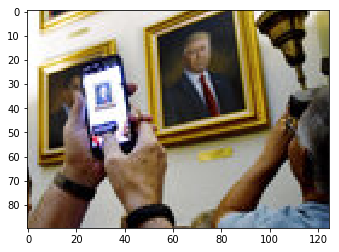

In [62]:
# knn example use case

# test article
test_id, test_tags, train_data = train_test(train)
print('Test Article Tags:', test_tags)
print()
show_images(article_images[test_id], image_to_caption)

Text to Text

Caption: Senate Judiciary Committee Chairman Lindsey Graham, R-S.C., joined at right by Sen. Dianne Feinstein, D-Calif., the ranking member, speaks during a contentious markup in his panel as he tries to change asylum laws as a way to address the migrant crisis at the southern border, on Capitol Hill in Washington, Thursday, Aug. 1, 2019. (AP Photo/J. Scott Applewhite)
50f030faa68241d8bc41591e4380be2a

Caption: Senate Minority Leader Chuck Schumer, D-N.Y., talks to reporters after the budget package just passed in the Senate to permit the government to resume borrowing to pay all of its obligations and would remove the prospect of a government shutdown in October, at the Capitol in Washington, Thursday, Aug. 1, 2019. (AP Photo/J. Scott Applewhite)

Caption: President Donald Trump speaks about the mass shootings in El Paso, Texas and Dayton, Ohio, in the Diplomatic Reception Room of the White House, Monday, Aug. 5, 2019, in Washington. (AP Photo/Evan Vucci)
21fe8afeb64a45c2b148317e07d71

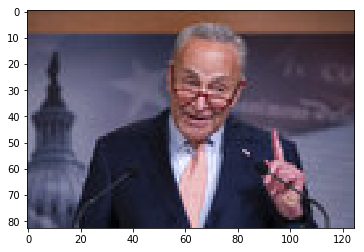

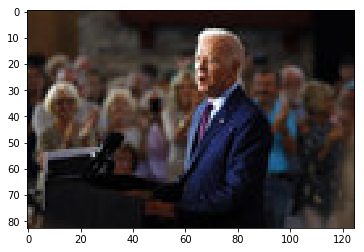

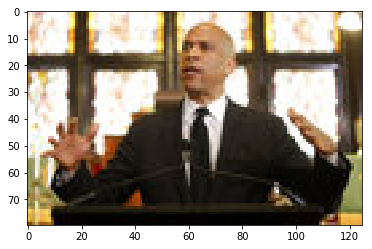

In [63]:
# model output

model = Text_to_Text_KNN(3, article_images)
model.fit(train_data)
train_ids, preds = model.predict(test_tags)
show_images(preds.keys(), image_to_caption)

Text to Image

Scores: [0.37142857142857144, 0.34285714285714286, 0.34285714285714286]
Caption: Republican state Sen. Paul Hornback on Thursday, Aug. 8, 2019, discusses a gun safety proposal that’s being drafted for introduction in the 2020 Kentucky legislative session. Hornback was joined by GOP Sen. Julie Raque Adams and Democratic Sen. Morgan McGarvey to discuss the bill, which would allow courts to issue temporary orders barring someone from possessing guns based on some showing that they pose a danger to themselves or others.

Caption: Political protesters approach the New Mexico state Capitol in Santa Fe, N.M., on horseback Tuesday, March 12, 2019. Advocates for gun rights in New Mexico including rural ranchers joined with a interstate group called Cowboys for Trump at a protest against Democrat-sponsored gun control legislation and a bill that removes the state's dormant ban on abortion. Democratic New Mexico Gov. Michelle Lujan Grisham last week signed a bill to expand background checks on pr

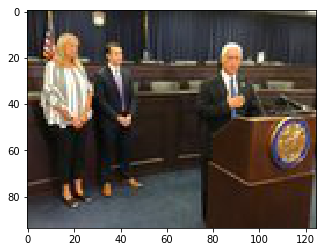

In [64]:
# model output for above article

model = Text_to_Image_KNN(3)
model.fit(image_train)
preds, scores = model.predict(test_tags)
print('Scores:', scores)
show_images(preds, image_to_caption)

#### Test Case 2: User Inputs Any Text, Tags with Tagging API

Define Input

In [66]:
# knn example use case
# Tagging API Demo use case
text =  "Georgia Tech’s schedule to this point has been light, with a season-opener against Tennessee the hardest test to this" \
    " point. Miami (4-0, 2-0) is looking for its first 10-game win streak since 2003-04. If it is looking for inspiration, Georgia Tech can look to" \
" 2015, when it stunned ninth-ranked Florida State on a last-second blocked field goal return for a 78-yard touchdown. FSU entered that" \
" game with a 29-game win streak over ACC opponents. Miami has beaten its last six ACC foes. Georgia Tech ranks 31st in points" \
" (36.5), 35th in yards per play (6.35) and unsurprisingly, second nationally in rushing yards per game (396.0). The Yellow Jackets" \
" average 5.91 yards per carry (10th), which ranks behind Miami’s 6.40, which is sixth. Georgia Tech hasn’t finished behind Miami — or" \
" anywhere outside the top 20 — in rushing yards per carry since at least 2008.Quarterback TaQuon Marshall, a converted running back" \
" (current running back, really, in Paul Johnson‘s offense), has been a capable leader"
test_tags = tagging_api(text)
print('Test Article Tags:', test_tags)

Test Article Tags: ['Football', 'College sports', 'Georgia Tech Yellow Jackets football', 'College football', 'Sports', 'Paul Johnson', 'Atlantic Coast Conference football', 'TaQuon Marshall']


Text to Text KNN

Caption: FILE - In this Thursday, Dec. 20, 2018, file photo, Harvey Weinstein, center, leaves New York Supreme Court in New York. Harvey Weinstein’s lawyers are arguing against the sex trafficking claims of an actress who the disgraced movie-making mogul says is capitalizing on the legal successes of other women. The lawyers filed papers Friday, June 21, 2019 in Manhattan federal court to try to toss out the trafficking claims made by Wedil David. (AP Photo/Mark Lennihan, File)
30d4efb9f17a4aa786f2018cf718756a

Caption: FILE - In this May 29, 2019 file photo, Golden State Warriors guard Stephen Curry smiles during practice for the NBA Finals against the Toronto Raptors in Toronto. The Golden State Warriors superstar is strategically producing content that focuses on sports, family and faith through Unanimous Media, which he co-founded with Jeron Smith and Erick Peyton. The newly-formed production company already has several projects under its belt including a major studio film, network

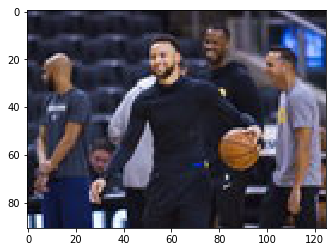

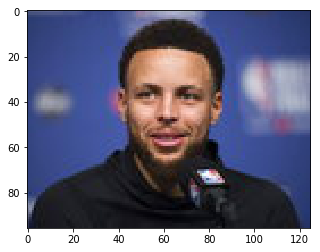

In [67]:
# model output

model = Text_to_Text_KNN(3, article_images)
model.fit(train)
train_ids, preds = model.predict(test_tags)
show_images(preds.keys(), image_to_caption)

Text to Image KNN

In [68]:
# model output for above article

model = Text_to_Image_KNN(3)
model.fit(image_train)
preds, scores = model.predict(test_tags)
print('Scores:', scores)
show_images(preds, image_to_caption)

Scores: [0.0, 0.0, 0.0]
Caption: FILE - In this Dec. 12, 2018 file photo, Michael Avenatti, lawyer for porn star Stormy Daniels, speaks outside court in New York. U.S. prosecutors announced Monday, March 25, 2019 they have charged Avenatti with extortion and bank and wire fraud. A spokesman for the U.S. attorney in Los Angeles said Avenatti was arrested Monday in New York. (AP Photo/Julio Cortez, File)
0002c8b6322446a8a9b8f8abaccb4430

Caption: In this Tuesday, May 14, 2019, photo an elderly woman holds a sport newspaper in Karpenisi town at Evrytania region, in central Greece. As balloting for the European Parliament gets underway Thursday and continues through Sunday voters over 55 are emerging as a powerful bloc on a rapidly aging continent as younger voters stay away from the polls in growing numbers. (AP Photo/Thanassis Stavrakis)
00036662b297400ca0c0819173d61efd

Caption: Missouri Gov. Mike Parson signs one of the nation's most restrictive abortion bills, banning the procedure on